# CARNEGIE MELLON UNIVERSITY

**Name**: Junxiao Guo

**Andrew ID**: junxiaog

**Course**: DATA, INFERENCE & APPLIED MACHINE LEARNING (COURSE 18-785)

**ASSIGNMENT 4**

In [10]:
%config IPCompleter.greedy=True
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install sklearn
!pip install seaborn
!pip install RegscorePy

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import matplotlib.dates as mdates 
import seaborn as seabornInstance 
import sys
import datetime as dt
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn                        import metrics, svm
from sklearn.linear_model           import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import utils
%matplotlib inline


## Question 1

In [12]:
def get_monthly_retrun(inputarr):
    mr = []
    for i in range(1,len(inputarr)):
        mr.append((inputarr[i]-inputarr[i-1])/inputarr[i-1])
    return np.array(mr)

Interception:  [0.00404784]
weights: 
[[0.09324143]]
Correlation Coefficient:0.026551295701909897   p value:0.6409049000032367


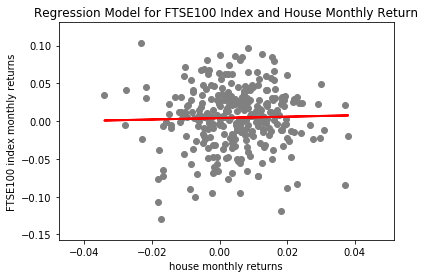

In [13]:
f_monthly = pd.read_excel('monthly.xls',sheet_name='Monthly')
f_ftse = pd.read_csv('FTSE100.csv')
house_date,house_price = f_monthly['Unnamed: 0'],f_monthly['Average House Price']
housepos = f_monthly.loc[f_monthly['Unnamed: 0'] == '2016-12-01'].index[0]
house_date,house_price = house_date[:housepos+1],house_price[:housepos+1]
ftse_date,ftse_index = f_ftse['Date'].astype('datetime64[ns]') ,f_ftse['Adj Close']
# FTSE monthly return
ftse_list = np.array(ftse_index)[::-1]
house_list = np.array(house_price)
ftse_mr,house_mr = get_monthly_retrun(ftse_list),get_monthly_retrun(house_list)
Y = ftse_mr.reshape(-1,1)  # Dependent variable
X = house_mr.reshape(-1,1) # Explanatory Variable
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X, Y) #training the algorithm
# print(ftse_mr)
corr_coef = stats.pearsonr(house_mr, ftse_mr)
print("Interception: ",regressor.intercept_)
print('weights: ')
print(regressor.coef_)
print("Correlation Coefficient:{}   p value:{}".format(corr_coef[0],corr_coef[1]))
y_pred = regressor.predict(X)
plt.scatter(X, Y,  color='gray')
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel("house monthly returns")
plt.ylabel("FTSE100 index monthly returns")
plt.title("Regression Model for FTSE100 Index and House Monthly Return")
plt.show()


## Answer 1

### I. What do the result tell us

- Since the Correlation Coefficient is very positively small, the result tells us that the FTSE index monthly return does not have a strong relationship between FTSE100 index

### II. Hypothsis to bakcup conclusion about existence of a signifcant relationship between these two variables

T test on the samples (two sample)

In [14]:
t_result = scipy.stats.ttest_ind(ftse_mr,house_mr)
print(t_result)


Ttest_indResult(statistic=0.011406194343330636, pvalue=0.9909030401555481)


## Question 2

In [15]:
college_info = pd.read_csv('College.csv')
college_info = college_info.rename(columns={'Unnamed: 0':'Name'})
college_namedf = college_info['Name']
newdf = college_info[["Apps","Enroll","Outstate","Top10perc","Top25perc"]].copy()
print("********* Correlation coefficients of the variables *********")
corrdf = college_info[["Apps","Enroll","Outstate","Top10perc","Top25perc","Grad.Rate"]].copy()
print(corrdf.corr()) # Correlation Coeficient

********* Correlation coefficients of the variables *********
               Apps    Enroll  Outstate  Top10perc  Top25perc  Grad.Rate
Apps       1.000000  0.846822  0.050159   0.338834   0.351640   0.146755
Enroll     0.846822  1.000000 -0.155477   0.181294   0.226745  -0.022341
Outstate   0.050159 -0.155477  1.000000   0.562331   0.489394   0.571290
Top10perc  0.338834  0.181294  0.562331   1.000000   0.891995   0.494989
Top25perc  0.351640  0.226745  0.489394   0.891995   1.000000   0.477281
Grad.Rate  0.146755 -0.022341  0.571290   0.494989   0.477281   1.000000


### b) c) StepWise linear regression Model and BIC"

In [16]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm
X = newdf
y = college_info['Grad.Rate']
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            print("-------------------")
            print(model.summary())
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add Variable:  {:10} | p-value {:.5}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        print("-------------------")
        print(model.summary())
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.5}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included,model

result,model = stepwise_selection(X, y)

print("Reult Model: {}".format(model.summary()))
print('Most Useful Variables:')
print(result)

# predy = model.predict(X['Outstate'])
# print(X['Outstate'])

-------------------
                            OLS Regression Results                            
Dep. Variable:              Grad.Rate   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     375.5
Date:                Sun, 13 Oct 2019   Prob (F-statistic):           1.63e-68
Time:                        22:45:51   Log-Likelihood:                -3158.0
No. Observations:                 777   AIC:                             6320.
Df Residuals:                     775   BIC:                             6329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9951      1.408

-------------------
                            OLS Regression Results                            
Dep. Variable:              Grad.Rate   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     156.5
Date:                Sun, 13 Oct 2019   Prob (F-statistic):           2.83e-79
Time:                        22:45:51   Log-Likelihood:                -3127.1
No. Observations:                 777   AIC:                             6262.
Df Residuals:                     773   BIC:                             6281.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2401      1.641

/Users/robert/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/robert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


### e) Compare the accurate of the model using only useful predictors with the one of the model using all five predictors? (5 points)

In [17]:

regressor_5 = sm.OLS(y, sm.add_constant(newdf)).fit()
y_pred_5 = regressor_5.predict(sm.add_constant(newdf))
regressor_2 = sm.OLS(y, sm.add_constant(newdf[['Outstate','Top25perc']])).fit()
y_pred_2 = regressor_2.predict(sm.add_constant(newdf[['Outstate','Top25perc']]))
from sklearn.metrics import mean_squared_error 
mse_dict = {}
mse_dict['mse_5variables'] = mean_squared_error(y_pred_5,y)
mse_dict['mse_2variables'] = mean_squared_error(y_pred_2,y)
for i in mse_dict.keys():
    print("{}: {}".format(i,mse_dict[i]))




mse_5variables: 180.89546889773055
mse_2variables: 183.3690660289117


### f) Given a set of predictor corresponding to Carnegie Mellon University, what graduation rate value should the most accurate model predict? (5 points)

In [18]:
print("Ground Truth:",y[87])
print(y_pred_5[87])


Ground Truth: 74
89.20112305346848


### Answer: Most accurate model  is using the model of  number of applications received, with the graduation rate of 89.20112305346848%

## Question 3

### Data Set

[City of Chicago Speed Camera Violations](https://catalog.data.gov/dataset/speed-camera-violations-997eb) from data.gov (from 2014-07-01 to 2019-09-24 ), the data points I'm choosing are the time records and number of speed violations recored by the camera for every corresponding time.

### My Assumption

The monthly average speed violations decreseas along with time.


### Methology

Algorithm used: Linear Regression

**Procedure**
1. Used data from 2014-07 to 2016-03 as the training dataset
2. Used the trained model to predict the speed violations from 2016-01 to 2019-07

### Conclusions

The trained model mostly corretly reflected the actual result, though for the time period from Janurary 2019 to July 2019, there is a highly non-linear flucturation of the speed violations, so fo that part the model didn't reflect the true result accurately

To sum up, my assumption holds true since the trend of monthly average speed violations for the city of Chicago decreased along with time.








0        2019-09-24
1        2019-09-24
2        2019-09-24
3        2019-09-24
4        2019-09-24
            ...    
201167   2014-07-01
201168   2014-07-01
201169   2014-07-01
201170   2014-07-01
201171   2014-07-01
Name: VIOLATION DATE, Length: 201172, dtype: datetime64[ns]


/Users/robert/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


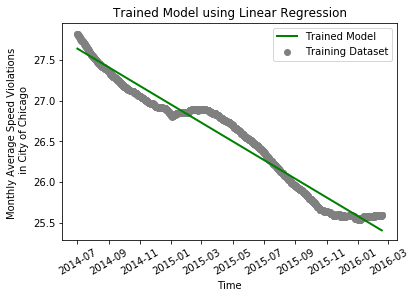

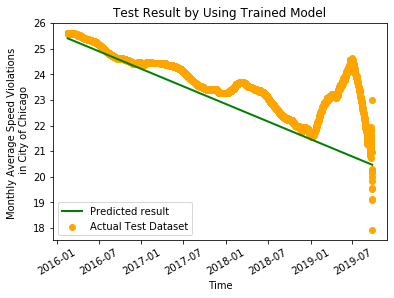

In [19]:
##### DATA INITIALIZATION #####
scvdf = pd.read_csv("Speed_Camera_Violations.csv")
scvdf["VIOLATION DATE"] = pd.to_datetime(scvdf["VIOLATION DATE"])
print(scvdf["VIOLATION DATE"])
violate_date = np.array(scvdf["VIOLATION DATE"].map(dt.datetime.toordinal)).reshape(-1,1)
violate_cnt = np.array(scvdf["VIOLATIONS"])
start = 0
violate_mean = []
adjusted_timestamp = []
adjusted_time = []
for i in range(30,len(violate_cnt),30):
    violate_mean.append(violate_cnt[start:i].mean())
    adjusted_timestamp.append(violate_date[i-30])
    adjusted_time.append(dt.datetime.fromordinal(violate_date[i-30]))
##### Split the portion for Training and Testing #####
TRAIN_PORTION = 1-0.3
train_len = int(len(violate_mean) * TRAIN_PORTION) # Set the portion for training
test_len = len(violate_mean) - train_len # The rest portion for testing
Y_train = violate_mean[train_len:]  
X_train = adjusted_timestamp[train_len:] 
Y_test = violate_mean[:train_len]  
X_test = adjusted_timestamp[:train_len]
regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm
##### TRAIN #####
Y_pred = regressor.predict(X_train)
plt.scatter(X_train, Y_train,  color='gray',label="Training Dataset")
pred_date = [dt.datetime.fromordinal(i) for i in X_train]
train_date = [dt.datetime.fromordinal(i) for i in X_train]
plt.plot(train_date, Y_pred, color='green', linewidth=2,label="Trained Model")
plt.xlabel("Time")
plt.ylabel("Monthly Average Speed Violations \n in City of Chicago")
plt.xticks(rotation=30)
plt.title("Trained Model using Linear Regression")
plt.legend()
plt.show()
##### TEST #####
Y_pred = regressor.predict(X_test)
plt.scatter(X_test, Y_test,  color='orange',label='Actual Test Dataset')
pred_date = [dt.datetime.fromordinal(i) for i in X_test]
train_date = [dt.datetime.fromordinal(i) for i in X_train]
plt.plot(pred_date, Y_pred, color='green', linewidth=2, label="Predicted result")
plt.xlabel("Time")
plt.ylabel("Monthly Average Speed Violations \n in City of Chicago")
plt.title("Test Result by Using Trained Model")
plt.xticks(rotation=30)
plt.legend()
plt.show()



## Question 4

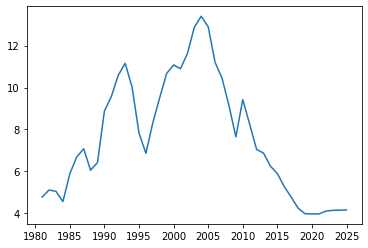

[3.974 3.974 3.984 4.25  4.775 5.275 5.9  ]


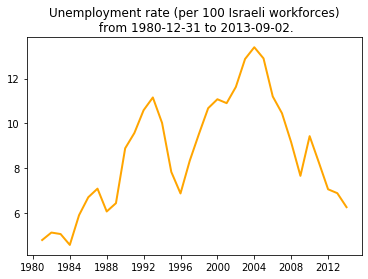

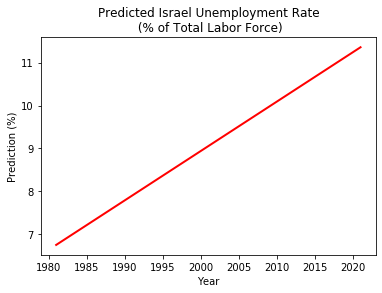

Predicted Unemployment Rate by year 2020:
2020-12-31 00:00:00 11.357757386015834%
2019-12-31 00:00:00 11.242362110712065%
2018-12-31 00:00:00 11.127282123045745%
2017-12-31 00:00:00 11.012202135379397%
2016-12-31 00:00:00 10.897122147713048%
2015-12-31 00:00:00 10.78172687240928%
2014-12-31 00:00:00 10.66664688474296%
Actual Unemployment Rate by year 2020:
2020-12-31 00:00:00 3.9739999999999998%
2019-12-31 00:00:00 3.9739999999999998%
2018-12-31 00:00:00 3.984%
2017-12-31 00:00:00 4.25%
2016-12-31 00:00:00 4.775%
2015-12-31 00:00:00 5.275%
2014-12-31 00:00:00 5.9%
MAPE: [145.78642239]%


In [20]:
from sklearn.kernel_ridge import KernelRidge
isr_lur = pd.read_csv("ODA-ISR_LUR.csv")
original_date = np.array(pd.to_datetime(isr_lur['Date']).map(dt.datetime.toordinal)).reshape(-1,1)
original_date = [dt.datetime.fromordinal(i) for i in original_date]
plt.plot(original_date,isr_lur['Value'])
plt.show()
endpos = isr_lur.loc[isr_lur['Date'] == '2013-12-31'].index[0]
endpos_2020 = isr_lur.loc[isr_lur['Date'] == '2020-12-31'].index[0]
trueval_2020 = np.array(isr_lur['Value'])[4:11]
print(trueval_2020)
date_to_2020 = np.array(pd.to_datetime(isr_lur.tail(len(isr_lur)-endpos_2020)['Date']).map(dt.datetime.toordinal)).reshape(-1,1)
isr_lur = isr_lur.tail(len(isr_lur)-endpos)
isr_lur['Date'] = pd.to_datetime(isr_lur['Date'])
isr_lur_val = np.array(isr_lur['Value'])

plt.plot(isr_lur['Date'], isr_lur_val, color='orange', linewidth=2)
plt.title("Unemployment rate (per 100 Israeli workforces)\n from 1980-12-31 to 2013-09-02.")
plt.show()
isr_lur_date = np.array(isr_lur['Date'].map(dt.datetime.toordinal))

X = isr_lur_date.reshape(-1,1)  # Dependent variable
Y = isr_lur_val.reshape(-1,1) # Explanatory Variable
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=0)
X_train, Y_train = X,Y

#################Choose Regressor#################
# regressor = LogisticRegression()
# regressor = SVR()
# regressor = KernelRidge(alpha=.03)
regressor = LinearRegression()
################Training##########################
regressor.fit(X_train, Y_train) #training the algorithm
#To retrieve the intercept:
# print("Interception: ",regressor.intercept_)
# print("Correlation Coefficient:",regressor.coef_)
y_pred = regressor.predict(date_to_2020)
x_date = [dt.datetime.fromordinal(i) for i in date_to_2020]
plt.plot(x_date, y_pred, color='red', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Prediction (%)")
plt.title("Predicted Israel Unemployment Rate\n (% of Total Labor Force)")
plt.show()
print("Predicted Unemployment Rate by year 2020:")
for i in range(7):
    print("{} {}%".format(x_date[i],y_pred[i][0]))
print("Actual Unemployment Rate by year 2020:")
for i in range(7):
    print("{} {}%".format(x_date[i],trueval_2020[i]))

#MAPE for accuracy
import numpy as np
def mape(y_true, y_pred):
    tot = 0
    for i in range(7):
        tot += abs(y_true[i] - y_pred[i])/y_true[i]
    return (tot/7)*100
q4_accuracy = mape(y_true=trueval_2020,y_pred=y_pred)
print("MAPE: {}%".format(q4_accuracy))
